Start

In [ ]:
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Class weights: {class_weight_dict}")

# Train with class weights
model_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weight_dict
)
model_balanced.fit(X_train, y_train)

# Evaluate balanced model
y_pred_balanced = model_balanced.predict(X_val)
accuracy_balanced = accuracy_score(y_val, y_pred_balanced)

print(f"\nBalanced Model Accuracy: {accuracy_balanced:.3f}")
print("Balanced Classification Report:")
print(classification_report(y_val, y_pred_balanced))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_balanced)
print("Confusion Matrix:")
print(cm)

Class weights: {np.int64(0): np.float64(0.5888088481408718), np.int64(1): np.float64(3.3150348217943466)}

Balanced Model Accuracy: 0.963
Balanced Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3388
           1       0.93      0.84      0.88       659

    accuracy                           0.96      4047
   macro avg       0.95      0.91      0.93      4047
weighted avg       0.96      0.96      0.96      4047

Confusion Matrix:
[[3344   44]
 [ 107  552]]


Top 20 Most Important Features:
                     feature  importance
40  sensor_17_rolling_mean_5    0.107165
34  sensor_11_rolling_mean_5    0.106745
28  sensor_04_rolling_mean_5    0.082921
42  sensor_20_rolling_mean_5    0.067948
24  sensor_02_rolling_mean_5    0.065974
26  sensor_03_rolling_mean_5    0.060675
36  sensor_12_rolling_mean_5    0.060623
44  sensor_21_rolling_mean_5    0.057193
13                 sensor_11    0.047731
30  sensor_07_rolling_mean_5    0.045075
14                 sensor_12    0.036864
9                  sensor_07    0.033064
32  sensor_09_rolling_mean_5    0.020771
16                 sensor_14    0.015800
57         cumulative_cycles    0.014990
11                 sensor_09    0.014911
38  sensor_14_rolling_mean_5    0.014051
22                 sensor_20    0.013837
15                 sensor_13    0.013620
5                  sensor_03    0.013381


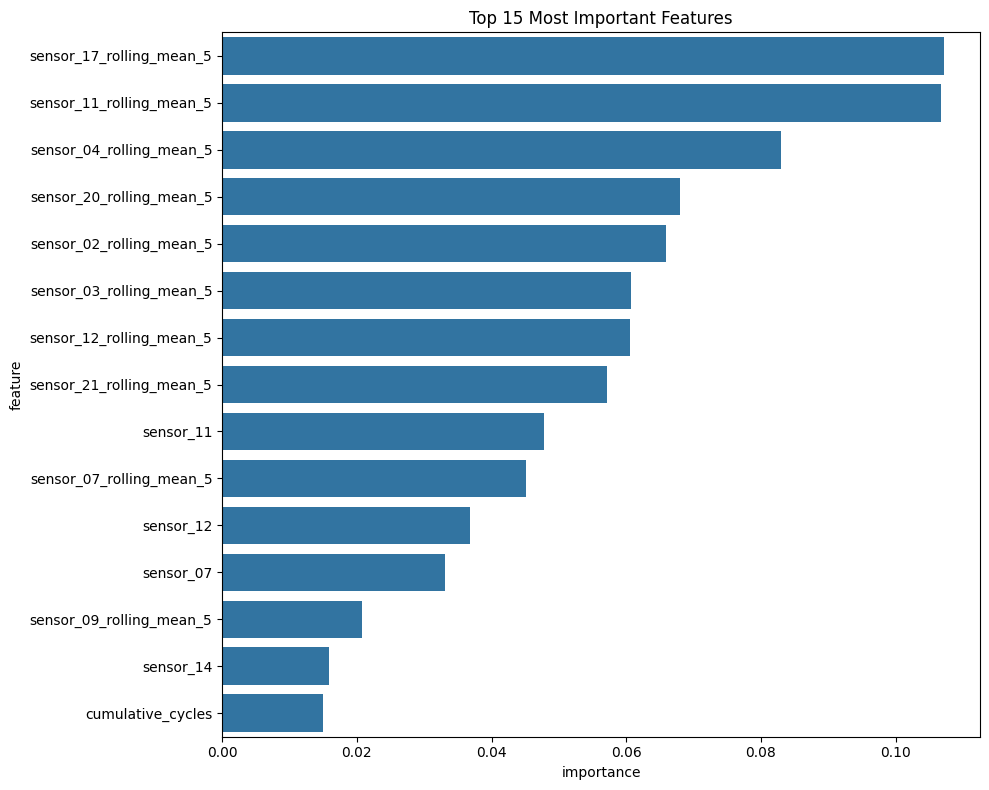

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model_balanced.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for Power BI dashboard
def prepare_dashboard_data(model, test_data, true_rul):
    # Create features for test data
    test_features = create_features(test_data)

    # Prepare test features
    test_feature_columns = [col for col in test_features.columns if col in feature_columns]
    X_test = test_features[test_feature_columns]

    # Make predictions
    test_predictions = model.predict(X_test)
    test_probabilities = model.predict_proba(X_test)[:, 1]

    # Create dashboard dataframe
    dashboard_df = test_features[['unit_id', 'time_cycles']].copy()
    dashboard_df['failure_probability'] = test_probabilities
    dashboard_df['predicted_failure'] = test_predictions
    dashboard_df['alert_level'] = pd.cut(test_probabilities,
                                       bins=[0, 0.3, 0.7, 1.0],
                                       labels=['Low', 'Medium', 'High'])

    # Add engine metadata
    engine_health = dashboard_df.groupby('unit_id').agg({
        'failure_probability': 'max',
        'predicted_failure': 'max',
        'alert_level': lambda x: x.value_counts().index[0]
    }).reset_index()

    return dashboard_df, engine_health

print("Preparing dashboard data...")
test_dashboard, engine_health = prepare_dashboard_data(model_balanced, test_data, true_rul)

print("Sample dashboard data:")
print(test_dashboard.head())
print(f"\nEngine health summary:")
print(engine_health.head())

Preparing dashboard data...
Sample dashboard data:
   unit_id  time_cycles  failure_probability  predicted_failure alert_level
4        1            5                  0.0                  0         NaN
5        1            6                  0.0                  0         NaN
6        1            7                  0.0                  0         NaN
7        1            8                  0.0                  0         NaN
8        1            9                  0.0                  0         NaN

Engine health summary:
   unit_id  failure_probability  predicted_failure alert_level
0        1                 0.00                  0         Low
1        2                 0.01                  0         Low
2        3                 0.12                  0         Low
3        4                 0.01                  0         Low
4        5                 0.01                  0         Low


In [ ]:
# Save data for Power BI
test_dashboard.to_csv('predictive_maintenance_dashboard_data.csv', index=False)
engine_health.to_csv('engine_health_summary.csv', index=False)

print("Dashboard data saved successfully!")
print(f"Dashboard records: {len(test_dashboard)}")
print(f"Engines monitored: {engine_health['unit_id'].nunique()}")

Dashboard data saved successfully!
Dashboard records: 12696
Engines monitored: 100


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Try different models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

print("Comparing different models...")
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    print(f"\n{name}:")
    print(f"  Cross-val Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"  Validation Accuracy: {accuracy:.3f}")

Comparing different models...

RandomForest:
  Cross-val Accuracy: 0.960 (+/- 0.013)
  Validation Accuracy: 0.963

GradientBoosting:
  Cross-val Accuracy: 0.960 (+/- 0.012)
  Validation Accuracy: 0.964

SVM:
  Cross-val Accuracy: 0.855 (+/- 0.082)
  Validation Accuracy: 0.857


In [ ]:
# Calculate business metrics
def calculate_business_metrics(y_true, y_pred, cost_fp=1000, cost_fn=5000):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    total_cost = (fp * cost_fp) + (fn * cost_fn)
    cost_savings = (fn * cost_fn) - total_cost  # Compared to no system

    metrics = {
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'total_cost': total_cost,
        'cost_savings': cost_savings,
        'maintenance_efficiency': tp / (tp + fp) if (tp + fp) > 0 else 0
    }
    return metrics

business_metrics = calculate_business_metrics(y_val, y_pred_balanced)
print("\n=== BUSINESS IMPACT ANALYSIS ===")
for metric, value in business_metrics.items():
    print(f"{metric}: {value}")

print(f"\nEstimated annual cost savings: ${business_metrics['cost_savings']:,.2f}")


=== BUSINESS IMPACT ANALYSIS ===
true_positives: 552
false_positives: 44
false_negatives: 107
total_cost: 579000
cost_savings: -44000
maintenance_efficiency: 0.9261744966442953

Estimated annual cost savings: $-44,000.00
